In [3]:
# Spark imports
import pyspark
from pyspark.rdd import RDD
from pyspark.sql import DataFrame, Row
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import desc
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, col, expr, concat, udf, array_contains
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, Word2Vec
from pyspark.ml.classification import DecisionTreeClassifier, LogisticRegression
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.regression import LabeledPoint
from pyspark.sql.types import ArrayType, StringType, FloatType, IntegerType
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import countDistinct
from pyspark.sql.types import DoubleType

# Others
from csv import reader
import csv
import os
import sys
import matplotlib.pyplot as plt
from collections import defaultdict

In [11]:
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Python Spark SQL basic example") \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()
    return spark

Investigate the original dataset (obviously, it cannot be used). Take a look at https://stackoverflow.com/questions/13793529/r-error-invalid-type-list-for-variable to see how useless the Body column information could be!

The point here is that the body information consists mostly of codes and some weird patterns that are not useful for our purpose. The most important information here is the connection between the title of the questions and tags. So, I removed the Body column from the dataset.

For removing the Body column, I read all the dataset once using Pandas library. After that, I removed the column and got an export to have a concrete file as our dataset. This part has been ommited from the notebook.

In [12]:
spark = init_spark()
filename = "./TrainWithoutBody.csv"
df1 = spark.read.option("multiLine", 'true').option("escape","\'").csv(filename, header=True)
df1 = df1.drop("_c0")
df1 = df1.dropna()
rddTags = df1.select("Tags").rdd

df1.count()

6017243

# Finding the 100 most used tags (one DT per each most used tag)

In [13]:
splittedTags = rddTags.filter(lambda r: r[0] != None).flatMap(lambda r: r[0].split(" ")).map(lambda r: r.replace(".", "")).map(lambda r: (r, 1)).reduceByKey(lambda x, y: x + y)

splittedTags = splittedTags.sortBy(lambda r: r[1], False) #Sorted with number of usage (you can collect and see)

### Tag v/s Count Distribution for all tags

+-------------+------+
|          tag| count|
+-------------+------+
|           c#|461574|
|         java|410466|
|          php|390630|
|   javascript|364076|
|      android|319310|
|       jquery|304343|
|          c++|198261|
|       python|183945|
|       iphone|182853|
|       aspnet|176610|
|        mysql|171367|
|         html|164795|
|          net|161728|
|          ios|135545|
|  objective-c|133391|
|          sql|131850|
|          css|128586|
|        linux|127003|
|ruby-on-rails|116184|
|      windows| 97652|
+-------------+------+
only showing top 20 rows



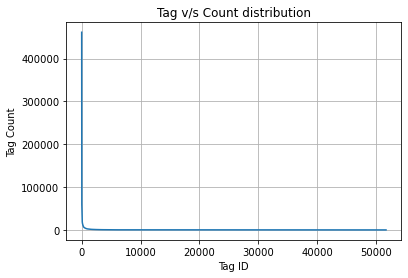

In [5]:
tagCountDF = splittedTags.toDF(["tag", "count"])
tagCountDF.show()
cCount = tagCountDF.select("count").collect()
plt.plot([i for i in range(splittedTags.count())], cCount)
plt.title("Tag v/s Count distribution")
plt.ylabel("Tag Count")
plt.xlabel("Tag ID")
plt.grid()

### Tag v/s Count Distribution for the top 500 tags

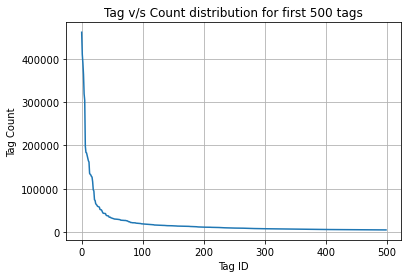

In [6]:
plt.plot([i for i in range(500)], cCount[:500])
plt.title("Tag v/s Count distribution for first 500 tags")
plt.ylabel("Tag Count")
plt.xlabel("Tag ID")
plt.grid()

### Tag v/s Count Distribution for the top 100 tags

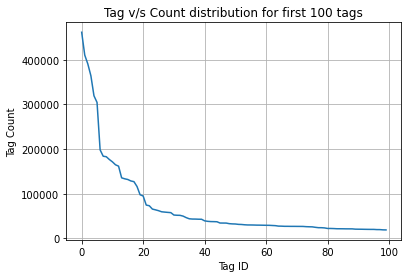

In [7]:
plt.plot([i for i in range(100)], cCount[:100])
plt.title("Tag v/s Count distribution for first 100 tags")
plt.ylabel("Tag Count")
plt.xlabel("Tag ID")
plt.grid()

### Tag v/s Count Distribution for the 10 best tags

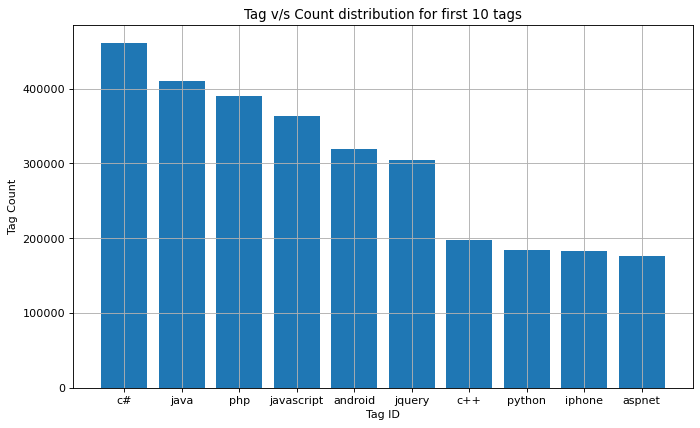

In [8]:
cTag = tagCountDF.select("tag").take(10)

plt.figure(figsize=(10, 6), dpi=80)
plt.bar([i for i in range(10)], [r.__getitem__("count") for r in cCount[:10]], tick_label=[r.__getitem__("tag") for r in cTag])
plt.title("Tag v/s Count distribution for first 10 tags")
plt.ylabel("Tag Count")
plt.xlabel("Tag ID")
plt.grid()

In [14]:
splittedTagsSorted = splittedTags.map(lambda r: r[0]) #Delete this line if you want to see number of times they have been used.
mostUsedTags = splittedTagsSorted.collect()[0:50]
# uncomment bellow to display all mostUsedTags
# mostUsedTags

In [15]:
mostUsedTags

['c#',
 'java',
 'php',
 'javascript',
 'android',
 'jquery',
 'c++',
 'python',
 'iphone',
 'aspnet',
 'mysql',
 'html',
 'net',
 'ios',
 'objective-c',
 'sql',
 'css',
 'linux',
 'ruby-on-rails',
 'windows',
 'c',
 'sql-server',
 'ruby',
 'wpf',
 'xml',
 'ajax',
 'database',
 'regex',
 'windows-7',
 'aspnet-mvc',
 'xcode',
 'django',
 'osx',
 'arrays',
 'vbnet',
 'eclipse',
 'json',
 'facebook',
 'ruby-on-rails-3',
 'ubuntu',
 'performance',
 'networking',
 'string',
 'multithreading',
 'winforms',
 'security',
 'aspnet-mvc-3',
 'visual-studio-2010',
 'bash',
 'homework']

# TF-IDF Title

## Sampling

In [10]:
df1 = df1.sample(0.001, 42)

## Clean up tags to include only most-used tags

In [11]:
def cleanUpTags(tags):
    tags = tags.split(" ")
    tags = [tag for tag in tags if tag in mostUsedTags]
    return tags

cleanUpTagsUDF = udf(cleanUpTags, ArrayType(StringType()))

df1 = df1.withColumn("cleantags",  cleanUpTagsUDF(col("tags")))

## Remove questions that do not include the top 50 tags

In [12]:
def filterEmptyRows(tags):
    return len(tags)

filterEmptyRowsUDF = udf(filterEmptyRows, IntegerType())

df1 = df1.filter(filterEmptyRowsUDF(col("cleantags")) > 0)

## Subject titles to TF-IDF

In [13]:
tokenizer = Tokenizer(inputCol="Title", outputCol="transformed_Title")
wordsData = tokenizer.transform(df1)

hashingTF = HashingTF(inputCol="transformed_Title", outputCol="rawFeatures")
featurizedData = hashingTF.transform(wordsData)

idf = IDF(inputCol="rawFeatures", outputCol="features")
idfModel = idf.fit(featurizedData)
df1 = idfModel.transform(featurizedData)

## Add 0/1 column for each tag

In [14]:
for tag in mostUsedTags:
    df1 = df1.withColumn(tag, (array_contains(col("cleantags"), tag)).cast('integer'))

df1.select("cleantags", "c#").show()

+--------------------+---+
|           cleantags| c#|
+--------------------+---+
|                [c#]|  1|
|                [c#]|  1|
|     [php, facebook]|  0|
|           [android]|  0|
|                [c#]|  1|
|               [c++]|  0|
|            [python]|  0|
|     [java, android]|  0|
|                [c#]|  1|
|        [php, mysql]|  0|
|[java, android, e...|  0|
|       [objective-c]|  0|
|        [php, mysql]|  0|
|[ruby-on-rails, r...|  0|
|               [c++]|  0|
|           [android]|  0|
|           [android]|  0|
|               [ios]|  0|
|           [c#, sql]|  1|
|           [android]|  0|
+--------------------+---+
only showing top 20 rows



## Split data to train and test sets

In [15]:
train_data, test_data = df1.randomSplit([.7,.3],seed=1234)

# Train models

### Handling class imbalance using undersampling method

In [7]:
def underSample(training_data, etag):
    major_df = training_data.filter(col(etag) == 0)
    minor_df = training_data.filter(col(etag) == 1)
    ratio = int(major_df.count()/minor_df.count())
    
    sampled_majority_df = major_df.sample(False, 1/ratio)
    train_data = sampled_majority_df.unionAll(minor_df)
    
    return train_data

<h3> Handling class imbalance with assigning class weights (higher weight to minority class) 

In [19]:
def classWeight(training_data, etag):
    balancingRatio = training_data.filter(col(etag) == 1).count() / training_data.count()
    calculateWeights = udf(lambda x: 1 * balancingRatio if x == 0 else (1 * (1.0 - balancingRatio)), DoubleType())
    
    training_data = training_data.withColumn("classWeightCol", calculateWeights(col(etag)))
    
    return training_data

def trainDTWithUndersampling(training_data, etag):
    
    # training_data = underSample(training_data, etag) #Commented for now
    training_data = classWeight(training_data, etag) #Can be commented for speedup

    model = DecisionTreeClassifier(featuresCol="features", labelCol=etag, maxDepth=4, impurity="gini", weightCol="classWeightCol").fit(training_data)

    # Using model without assigning classweight
    # model = DecisionTreeClassifier(featuresCol="features", labelCol=etag, maxDepth=4, impurity="gini").fit(training_data)
    pred = model.transform(test_data)
    
    tp = pred.filter((col(etag) == 1) & (col("prediction") == 1)).count()
    fp = pred.filter((col(etag) == 0) & (col("prediction") == 1)).count()
    fn = pred.filter((col(etag) == 1) & (col("prediction") == 0)).count()
    
    if tp + fp == 0:
        precision = 0
    else:  
        precision = tp / (tp + fp)
    if tp + fn == 0:
        recall = 0
    else:  
        recall = tp / (tp + fp)
    if precision + recall == 0:
        f1 = 0
    else:  
        f1 = 2 * (precision / (precision + recall))

    return model, pred, precision * 100, recall * 100, f1

def trainDTWithoutUndersampling(training_data, etag):
    
    # training_data = underSample(training_data, etag) #Commented for now
    training_data = classWeight(training_data, etag) #Can be commented for speedup

    model = DecisionTreeClassifier(featuresCol="features", labelCol=etag, maxDepth=4, impurity="gini").fit(training_data)
    pred = model.transform(test_data)
    
    tp = pred.filter((col(etag) == 1) & (col("prediction") == 1)).count()
    fp = pred.filter((col(etag) == 0) & (col("prediction") == 1)).count()
    fn = pred.filter((col(etag) == 1) & (col("prediction") == 0)).count()
    
    if tp + fp == 0:
        precision = 0
    else:  
        precision = tp / (tp + fp)
    if tp + fn == 0:
        recall = 0
    else:  
        recall = tp / (tp + fp)
    if precision + recall == 0:
        f1 = 0
    else:  
        f1 = 2 * (precision / (precision + recall))

    return model, pred, precision * 100, recall * 100, f1

def trainLRWithUndersampling(training_data, etag):
    
    # training_data = underSample(training_data, etag) #Commented for now
    training_data = classWeight(training_data, etag) #Can be commented for speedup
    model = LogisticRegression(featuresCol="features", labelCol=etag, maxIter=100, weightCol="classWeightCol").fit(training_data)

    # Using model without assigning classweight
    # model = LogisticRegression(featuresCol="features", labelCol=etag, maxIter=100).fit(training_data)
    pred = model.transform(test_data)
    
    tp = pred.filter((col(etag) == 1) & (col("prediction") == 1)).count()
    fp = pred.filter((col(etag) == 0) & (col("prediction") == 1)).count()
    fn = pred.filter((col(etag) == 1) & (col("prediction") == 0)).count()
    
    if tp + fp == 0:
        precision = 0
    else:  
        precision = tp / (tp + fp)
    if tp + fn == 0:
        recall = 0
    else:  
        recall = tp / (tp + fp)
    if precision + recall == 0:
        f1 = 0
    else:  
        f1 = 2 * (precision / (precision + recall))
    
    return model, pred, precision * 100, recall * 100, f1

def trainLRWithoutUndersampling(training_data, etag):
    
    # training_data = underSample(training_data, etag) #Commented for now
    model = LogisticRegression(featuresCol="features", labelCol=etag, maxIter=100).fit(training_data)
    pred = model.transform(test_data)
    
    tp = pred.filter((col(etag) == 1) & (col("prediction") == 1)).count()
    fp = pred.filter((col(etag) == 0) & (col("prediction") == 1)).count()
    fn = pred.filter((col(etag) == 1) & (col("prediction") == 0)).count()
    
    if tp + fp == 0:
        precision = 0
    else:  
        precision = tp / (tp + fp)
    if tp + fn == 0:
        recall = 0
    else:  
        recall = tp / (tp + fp)
    if precision + recall == 0:
        f1 = 0
    else:  
        f1 = 2 * (precision / (precision + recall))
    
    return model, pred, precision * 100, recall * 100, f1

## Train models for each tag and obtain precision, recall, and f-measure

In [ ]:
dtcs = defaultdict()
preds = defaultdict()
precisions = defaultdict()
recalls = defaultdict()
fmeasures = defaultdict()

In [30]:


for tag in mostUsedTags:
    if tag not in dtcs:
        dtcs[tag], preds[tag], precisions[tag], recalls[tag], fmeasures[tag] = trainDTWithUndersampling(train_data, tag)

for tag in mostUsedTags:
    if tag not in dtcs:
        dtcs[tag], preds[tag], precisions[tag], recalls[tag], fmeasures[tag] = trainDTWithoutUndersampling(train_data, tag)


In [ ]:
dtcs1 = defaultdict()
preds1 = defaultdict()
precisions1 = defaultdict()
recalls1 = defaultdict()
fmeasures1 = defaultdict()

In [ ]:
for tag in mostUsedTags:
    if tag not in dtcs1:
        try:
            dtcs1[tag], preds1[tag], precisions1[tag], recalls1[tag], fmeasures1[tag] = trainLRWithUndersampling(train_data, tag)
            print(tag)
        except:
            print('Passed: ' + str(tag))

for tag in mostUsedTags:
    if tag not in dtcs1:
        try:
            dtcs1[tag], preds1[tag], precisions1[tag], recalls1[tag], fmeasures1[tag] = trainLRWithoutUndersampling(train_data, tag)
            print(tag)
        except:
            print('Passed: ' + str(tag))

In [ ]:
print(precisions)
print(recalls)
print(fmeasures)

defaultdict(None, {'c#': 94.11764705882352, 'java': 100.0, 'php': 65.51724137931035, 'javascript': 52.307692307692314, 'android': 100.0, 'jquery': 79.66101694915254, 'c++': 89.47368421052632, 'python': 29.166666666666668, 'iphone': 65.21739130434783, 'aspnet': 0, 'mysql': 40.0, 'html': 47.22222222222222, 'net': 0, 'ios': 25.71428571428571, 'objective-c': 3.7037037037037033, 'sql': 36.11111111111111, 'css': 61.904761904761905, 'linux': 23.404255319148938, 'ruby-on-rails': 15.686274509803921, 'windows': 16.216216216216218, 'c': 19.35483870967742, 'sql-server': 27.500000000000004, 'ruby': 45.0, 'wpf': 88.88888888888889, 'xml': 41.37931034482759, 'ajax': 10.256410256410255, 'database': 10.81081081081081, 'regex': 93.33333333333333, 'windows-7': 10.714285714285714, 'aspnet-mvc': 0, 'xcode': 6.0606060606060606, 'django': 30.76923076923077, 'osx': 66.66666666666666, 'arrays': 14.583333333333334, 'vbnet': 0, 'eclipse': 37.5, 'json': 17.02127659574468, 'facebook': 100.0, 'ruby-on-rails-3': 18.7

# Word2Vec Title

Now we will be training the same models. This time however we will be using Word2Vec for the featurization of the titles. 

We first start by defining some constants and some utility functions.

In [4]:
num_labels = 50
classifier_array_title = []

def column_splitter(r):
    if not r.Tags:
        label_array = None
    else:
        tags = r.Tags.split(' ')
        label_array = []
        for t in mostUsedTags:
            if t in tags:
                label_array.append(1)
            else:
                label_array.append(0)
        if 1 not in label_array:
            label_array = None
    
    return (r.Id, r.Title, r.Tags, r.tokenized_text, label_array)


def init_spark_2():
    spark = SparkSession \
        .builder.appName("W2V with Title").config("spark.sql.broadcastTimeout", "72000").config('spark.shuffle.service.enabled', 'TRUE').config("spark.debug.maxToStringFields" , "100").config("spark.executor.heartbeatInterval", "14400").getOrCreate()
        
    return spark

We then can conveniantly take a previously processed dataframe with the sample set that also has the tokenised title

In [5]:
spark = init_spark_2()

w2v_data_title = wordsData

## Data Pre-processing

### Current State of Dataframe


In [8]:
w2v_data_title.take(1)    

[Row(_c0='0', Id='1', Title='How to check if an uploaded file is an image without mime type?', Tags='php image-processing file-upload upload mime-types')]

### Data Featurization, Sampling and Structure

In [9]:
train_df_pre_title, test_df_pre_title = w2v_data_title.randomSplit([.7,.3],seed=1234)

In [ ]:
w2v_data_title.take(1)

In [10]:
word2Vec = Word2Vec(inputCol="transformed_Title", outputCol="features", vectorSize=100)
fitted_word2Vec = word2Vec.fit(w2v_data_title)

train_df_pre_title = fitted_word2Vec.transform(train_df_pre_title)
test_df_pre_title = fitted_word2Vec.transform(test_df_pre_title)

In [11]:
spark.catalog.clearCache()
train_df_pre_title.take(1)

+-------+--------------------+--------------------+--------------------+--------------------+--------------------+
|     Id|               Title|                Tags|      tokenized_text|           tag_array|            features|
+-------+--------------------+--------------------+--------------------+--------------------+--------------------+
|1005419|Adjust scrollview...|             android|[adjust, scrollvi...|[0, 0, 0, 0, 1, 0...|[0.00550473170975...|
|1005517|How do I choose s...|bash directory re...|[how, do, i, choo...|[0, 0, 0, 0, 0, 0...|[-0.0091712700086...|
|1005802|malloc'd memory a...|      c linux malloc|[malloc'd, memory...|[0, 0, 0, 0, 0, 0...|[0.01267608208581...|
|1007700|Sending user curr...|iphone xcode goog...|[sending, user, c...|[0, 0, 0, 0, 0, 0...|[0.00810697026151...|
|1008904|Script to mirror ...|windows sql-serve...|[script, to, mirr...|[0, 0, 0, 0, 0, 0...|[0.02162850773893...|
|1011115|insert array into...|    php mysql arrays|[insert, array, i...|[0, 0, 1

### Seperate Label Array into Columns

In [12]:
train_df_title = train_df_pre_title.select(['Id']+['Tags']+['features']+['Tags']+['tokenized_text']+[expr('tag_array[' + str(x) + ']') for x in range(0, num_labels)])

for i in range(0, num_labels): 
    if '.' in mostUsedTags[i]:
        mostUsedTags[i] = mostUsedTags[i].replace('.', '')

colnames = ['Id']+['Tags']+['features']+['Tags']+['tokenized_text']+ [str(mostUsedTags[i]) for i in range(0, num_labels)] 
train_df_title = train_df_title.toDF(*colnames)

train_data = train_df_title

train_data.take(1)

In [13]:
test_df_pre_title = train_df_pre_title.select(['Id']+['Tags']+['features']+['Tags']+['tokenized_text']+[expr('tag_array[' + str(x) + ']') for x in range(0, num_labels)])

for i in range(0, num_labels): 
    if '.' in mostUsedTags[i]:
        mostUsedTags[i] = mostUsedTags[i].replace('.', '')

colnames = ['Id']+['Tags']+['features']+['Tags']+['tokenized_text']+ [str(mostUsedTags[i]) for i in range(0, num_labels)] 
test_df_pre_title = test_df_pre_title.toDF(*colnames)

test_data = test_df_pre_title

test_data.take(1)

## Train Models

In [17]:
w2v_lrs = defaultdict()
w2v_lrs_preds = defaultdict()
w2v_lrs_precisions = defaultdict()
w2v_lrs_recalls = defaultdict()
w2v_lrs_fmeasures = defaultdict()

w2v_dts = defaultdict()
w2v_dts_preds = defaultdict()
w2v_dts_precisions = defaultdict()
w2v_dts_recalls = defaultdict()
w2v_dts_fmeasures = defaultdict()

In [20]:
for tag in mostUsedTags:
    if tag not in w2v_lrs:
        try:
            w2v_lrs[tag], w2v_lrs_preds[tag], w2v_lrs_precisions[tag], w2v_lrs_recalls[tag], w2v_lrs_fmeasures[tag] = trainLRWithoutUndersampling(train_data, tag) 
            print('Trained: ' + str(tag)) 
        except:
            print('Passed: ' + str(tag))

PythonException: 
  An exception was thrown from Python worker in the executor. The below is the Python worker stacktrace.
Traceback (most recent call last):
  File "E:\Anaconda\anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\worker.py", line 585, in main
  File "E:\Anaconda\anaconda3\Lib\site-packages\pyspark\python\lib\pyspark.zip\pyspark\serializers.py", line 593, in read_int
    length = stream.read(4)
  File "E:\Anaconda\anaconda3\lib\socket.py", line 669, in readinto
    return self._sock.recv_into(b)
socket.timeout: timed out


In [ ]:
for tag in mostUsedTags:
    if tag not in w2v_dts:
        try:
            w2v_dts[tag], w2v_dts_preds[tag], w2v_dts_precisions[tag], w2v_dts_recalls[tag], w2v_dts_fmeasures[tag] = trainDTWithoutUndersampling(train_data, tag)
            print('Trained: ' + str(tag)) 
        except:
            print('Passed: ' + str(tag))

# SciKit Learn